# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Select FRILL columns](#Select-FRILL-columns)
* [Linear discriminant analysis of FRILL embeddings](#Linear-discriminant-analysis-of-FRILL-embeddings)
* [One-class linear discriminant analysis of FRILL embeddings](#One-class-linear-discriminant-analysis-of-FRILL-embeddings)
* [Local outlier factor of LDA components of FRILL embeddings](#Local-outlier-factor-of-LDA-components-of-FRILL-embeddings)
* [One-class SVM scores of the LDA components of the FRILL embeddings](One-class-SVM-scores-of-the-LDA-components-of-the-FRILL-embeddings)
* [SGDOneClassSVM scores of FRILL embeddings and resultant LDA components](#SGDOneClassSVM-scores-of-FRILL-embeddings-and-resultant-LDA-components)
* [Spherical coordinates](#Spherical-coordinates)
* [LDA components of spherical FRILL-based features](#LDA-components-of-spherical-FRILL-based-features)
* [One-class LDA components of spherical FRILL-based features](#One-class-LDA-components-of-spherical-FRILL-based-features)
* [Aggregate and scale](#Aggregate-and-scale)
* [Spot check](#Spot-check)
* [Discussion](#Discussion)

# Introduction

Three holdout datasets have been identified. This notebook featurizes them.

# Imports and configuration

In [55]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

time: 1e+03 µs


In [56]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
time: 2.86 ms


In [57]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from joblib import load as joblib_load
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# spherical coordinates
from numpy import arctan2, sqrt

# other sklearn
from sklearn.linear_model import SGDOneClassSVM
from sklearn.svm import OneClassSVM

# typing
from typing import Callable, List

# visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib widget
sns.set_theme(context="notebook", style="ticks", palette="colorblind")

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

time: 4.02 ms


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [58]:
# Location of exported feature extractors
FEATURE_EXTRACTORS = "."

# Location of holdout labels and FRILL columns
HOLDOUT = "../21.0-mic-prepare_holdout_datasets_for_evaluation"

# Location where this notebook will output
OUT_FOLDER = "."

_ = gc_collect()

time: 121 ms


# Setup

In [59]:
# valence label codes
VALENCE = {"neg": 0, "neu": 1, "pos": 2}
VALENCES = ("neg", "neu", "pos")
NEIGHBORS = (10, 20, 30)
OC_SVM = ("sgdlinear", "rbf", "sigmoid", "poly5", "poly6")

feature_trio = lambda prefix, suffix: [
    f"{f'{prefix}_' if prefix else ''}{valence}{f'_{suffix}' if suffix else ''}"
    for valence in VALENCES
]

load_extractor = lambda feature_file: joblib_load(
    f"{FEATURE_EXTRACTORS}/{feature_file}.joblib"
)


def spot_check(
    data: pd.DataFrame, labels: pd.DataFrame, expected_columns: List[str] = []
) -> None:
    """Spot check feature extraction process"""
    assert all(data.index == labels.index)
    assert not data.isnull().values.any()
    if expected_columns:
        assert list(data.columns) == expected_columns
    print(data.info())
    print(data.head())


_ = gc_collect()

time: 137 ms


In [60]:
def plot1d(data: pd.DataFrame, labels: pd.DataFrame, x: str) -> None:
    sns.displot(
        x=data[x],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
    )
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()


_ = -gc_collect()

time: 141 ms


In [61]:
def plot2d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str) -> None:
    """Scatterplot of two variables"""
    _ = sns.histplot(
        x=data[x],
        y=data[y],
        cmap="RdPu",
        linewidth=0,
        alpha=0.2,
        legend=False,
        kde=True,
    )
    _ = sns.scatterplot(
        x=data[x],
        y=data[y],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
        s=10,
    )
    sns.despine(**dict.fromkeys("top right left bottom".split(), True))
    plt.show()


_ = gc_collect()

time: 137 ms


In [62]:
def plot3d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str, z: str) -> None:
    """Scatterplot of three variables"""
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        data[x],
        data[y],
        data[z],
        alpha=0.5,
        linewidth=0,
        cmap="viridis",
        c=labels.valence,
    )
    ax.grid(False)
    plt.show()


_ = gc_collect()

time: 149 ms


In [63]:
def checkpoint_features(df: pd.DataFrame, features: List[str]) -> None:
    """Save features to disk as a .feather dataframe"""
    df = df.loc[:, features]
    df.columns = df.columns.astype(str)
    try:
        df.to_feather(
            _ := f"{OUT_FOLDER}/holdout_{'_-_'.join(features) if len(features) > 1 else features[0]}.feather"
        )
    except ValueError:
        df.reset_index().to_feather(_)


_ = gc_collect()

time: 126 ms


# Load data

In [64]:
frill = pd.read_feather(f"{HOLDOUT}/holdout_FRILL.feather")
labels = pd.read_feather(f"{HOLDOUT}/holdout_labels.feather").drop(columns="id")
spot_check(frill, labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 15.3 MB
None
          0         1         2         3         4         5         6  \
0 -0.035624  0.148898 -0.109508 -0.016199 -0.084427 -0.067872  0.174007   
1 -0.103035  0.082011  0.110948 -0.060209 -0.073397  0.009772 -0.020830   
2 -0.065101  0.038458 -0.029423  0.005429 -0.023002  0.152135  0.053979   
3  0.083481  0.138969 -0.030347  0.062699  0.073357 -0.039354 -0.089715   
4  0.019141  0.170539 -0.056348  0.032532 -0.089482  0.079703  0.037175   

          7         8         9  ...      2038      2039      2040      2041  \
0 -0.033383 -0.017896 -0.024012  ... -0.153698  0.041551 -0.003445 -0.059062   
1  0.044276  0.046892 -0.115516  ...  0.065289  0.075569 -0.089013 -0.161597   
2 -0.039011  0.017791 -0.077413  ... -0.042246 -0.004320 -0.040200 -0.049798   
3  0.113456  0.039636 -0.041954  ...  0.022920 -0.181787  0.011134 -0.073

In [65]:
frill = frill.loc[
    labels.emo != "sur"
]  # for the Thorsten data, we don't know the actual valence of surprise
labels = labels.loc[labels.emo != "sur"]
frill = frill.reset_index(drop=True)
labels = labels.reset_index(drop=True)
spot_check(frill, labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 12.9 MB
None
          0         1         2         3         4         5         6  \
0 -0.035624  0.148898 -0.109508 -0.016199 -0.084427 -0.067872  0.174007   
1 -0.103035  0.082011  0.110948 -0.060209 -0.073397  0.009772 -0.020830   
2 -0.065101  0.038458 -0.029423  0.005429 -0.023002  0.152135  0.053979   
3  0.083481  0.138969 -0.030347  0.062699  0.073357 -0.039354 -0.089715   
4  0.019141  0.170539 -0.056348  0.032532 -0.089482  0.079703  0.037175   

          7         8         9  ...      2038      2039      2040      2041  \
0 -0.033383 -0.017896 -0.024012  ... -0.153698  0.041551 -0.003445 -0.059062   
1  0.044276  0.046892 -0.115516  ...  0.065289  0.075569 -0.089013 -0.161597   
2 -0.039011  0.017791 -0.077413  ... -0.042246 -0.004320 -0.040200 -0.049798   
3  0.113456  0.039636 -0.041954  ...  0.022920 -0.181787  0.011134 -0.073

In [67]:
labels.reset_index(drop=True).to_feather(f"{OUT_FOLDER}/holdout_labels.feather")

time: 17 ms


# Select FRILL columns

In [12]:
selector = load_extractor("frill_column_selector")
selected_frill_columns = selector.get_feature_names_out(frill.columns)
frill = pd.DataFrame(selector.transform(frill), columns=selected_frill_columns)
spot_check(frill, labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Columns: 1024 entries, 0 to 2047
dtypes: float32(1024)
memory usage: 6.5 MB
None
          0         7        15        16        18        20        21  \
0 -0.035624 -0.033383  0.043033 -0.041507  0.226673  0.008828  0.176655   
1 -0.103035  0.044276  0.059442 -0.119909  0.345795  0.045072  0.067420   
2 -0.065101 -0.039011  0.028183 -0.048056  0.059421 -0.064515  0.084881   
3  0.083481  0.113456  0.039784 -0.049637  0.207155  0.128711  0.013286   
4  0.019141  0.046567  0.015699 -0.064816  0.255913  0.091518  0.044819   

         22        30        32  ...      2023      2024      2026      2028  \
0 -0.029301  0.070888  0.012144  ...  0.040793  0.047765 -0.024035 -0.051325   
1  0.050928 -0.068873  0.043356  ...  0.049300 -0.069195  0.022934  0.004956   
2 -0.066782  0.055454 -0.004342  ... -0.026597 -0.028739  0.078741  0.086177   
3  0.136444  0.035383 -0.020022  ... -0.000103  0.099276  0.011584 -0.0393

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [13]:
with open(f"{OUT_FOLDER}/selected_frill_columns.txt", "w") as f:
    for column in selected_frill_columns:
        _ = f.write(f"{column}\n")

time: 3 ms


# Linear discriminant analysis components of FRILL embeddings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LDA1    1657 non-null   float64
 1   LDA2    1657 non-null   float64
dtypes: float64(2)
memory usage: 26.0 KB
None
       LDA1      LDA2
0 -1.779908  0.802817
1 -2.094411  0.605967
2 -1.907842  1.678659
3 -0.634981  1.812536
4 -1.851669  1.633379


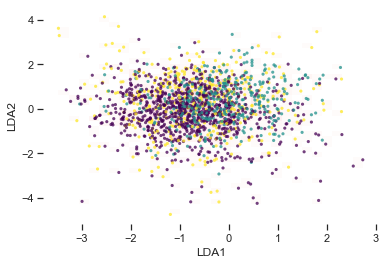

time: 327 ms


In [14]:
features = ["LDA1", "LDA2"]
data = pd.DataFrame(load_extractor("LDA1_-_LDA2").transform(frill), columns=features)
spot_check(data, labels)
plot2d(data, labels, *features)
checkpoint_features(data, features)

# One-class linear discriminant analysis of FRILL embeddings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LDA1       1657 non-null   float64
 1   LDA2       1657 non-null   float64
 2   ocLDA_neg  1657 non-null   float64
 3   ocLDA_neu  1657 non-null   float64
 4   ocLDA_pos  1657 non-null   float64
dtypes: float64(5)
memory usage: 64.9 KB
None
       LDA1      LDA2  ocLDA_neg  ocLDA_neu  ocLDA_pos
0 -1.779908  0.802817   0.130461  -1.576126   1.716082
1 -2.094411  0.605967   0.449498  -1.923062   1.758183
2 -1.907842  1.678659  -0.575112  -1.524096   2.470173
3 -0.634981  1.812536  -1.287103  -0.253904   1.788782
4 -1.851669  1.633379  -0.561800  -1.478384   2.400638


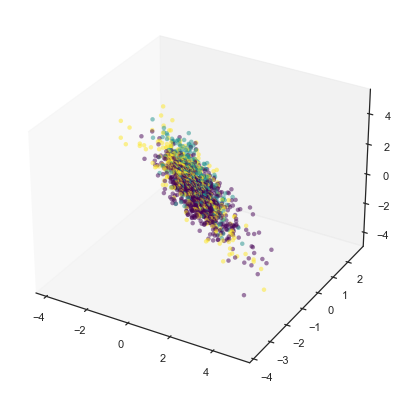

time: 773 ms


In [15]:
df = deepcopy(frill)
features = []
for valence in VALENCES:
    feature = f"ocLDA_{valence}"
    df[feature] = np.squeeze(
        load_extractor(feature).transform(df.loc[:, frill.columns])
    )
    features.append(feature)
    del feature
    _ = gc_collect()
data = pd.concat(
    [data, df.loc[:, feature_trio("ocLDA", "")]],
    axis="columns",
)
spot_check(data, labels)
plot3d(data, labels, *features)
checkpoint_features(data, features)

In [16]:
del df
_ = gc_collect()

time: 123 ms


# Local outlier factor of LDA components of FRILL embeddings

  0%|          | 0/3 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LDA1            1657 non-null   float64
 1   LDA2            1657 non-null   float64
 2   ocLDA_neg       1657 non-null   float64
 3   ocLDA_neu       1657 non-null   float64
 4   ocLDA_pos       1657 non-null   float64
 5   LDA-LOF_neg_30  1657 non-null   float64
 6   LDA-LOF_neu_30  1657 non-null   float64
 7   LDA-LOF_pos_30  1657 non-null   float64
dtypes: float64(8)
memory usage: 103.7 KB
None
       LDA1      LDA2  ocLDA_neg  ocLDA_neu  ocLDA_pos  LDA-LOF_neg_30  \
0 -1.779908  0.802817   0.130461  -1.576126   1.716082       -1.007021   
1 -2.094411  0.605967   0.449498  -1.923062   1.758183       -0.992824   
2 -1.907842  1.678659  -0.575112  -1.524096   2.470173       -1.010222   
3 -0.634981  1.812536  -1.287103  -0.253904   1.788782       -1.026993   
4 -1.851669  1.633379  -0.5

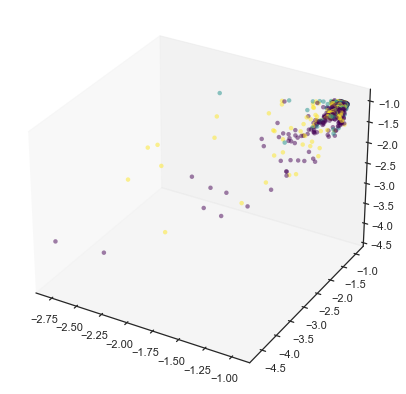

time: 726 ms


In [17]:
n_neighbors = 30
features = []
for valence in tqdm(VALENCES):
    feature = f"LDA-LOF_{valence}_{n_neighbors}"
    data[feature] = load_extractor(feature).score_samples(data.loc[:, ["LDA1", "LDA2"]])
    features.append(feature)
    del feature
    _ = gc_collect()

spot_check(data, labels)
plot3d(data, labels, *features)
checkpoint_features(data, features)

# One-class SVM scores of the LDA components of the FRILL embeddings

In [18]:
def extract_ocsvm_features(
    df: pd.DataFrame, labels: pd.DataFrame, descriptor: str
) -> pd.DataFrame:
    """Extract features using the given one-class SVM base"""
    prefix = f"ocSVM_{descriptor}"
    assert all(df.index == labels.index)

    # one-class scores of LDA components of FRILL embeddings
    print("extracting one-class scores of LDA components of FRILL embeddings...")
    for valence in VALENCE.keys():
        feature = f"LDA-{prefix}_{valence}"
        df[feature] = load_extractor(feature).score_samples(df.loc[:, ["LDA1", "LDA2"]])
        del feature
        _ = gc_collect()
    assert all(df.index == labels.index)
    features = [f"LDA-{prefix}_neg", f"LDA-{prefix}_neu", f"LDA-{prefix}_pos"]
    plot3d(df, labels, *features)
    checkpoint_features(df, features)

    return df


_ = gc_collect()

time: 117 ms


  0%|          | 0/5 [00:00<?, ?it/s]

extracting one-class scores of LDA components of FRILL embeddings...


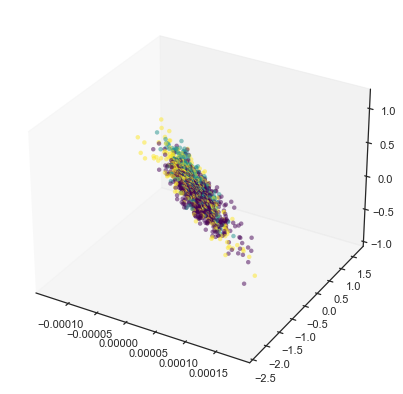

extracting one-class scores of LDA components of FRILL embeddings...


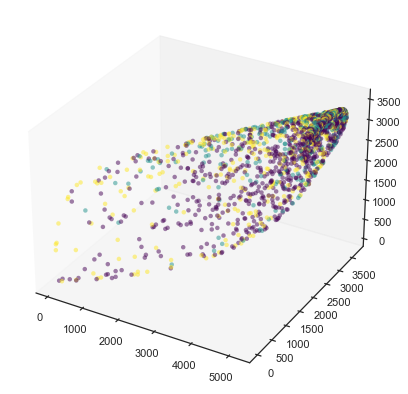

extracting one-class scores of LDA components of FRILL embeddings...


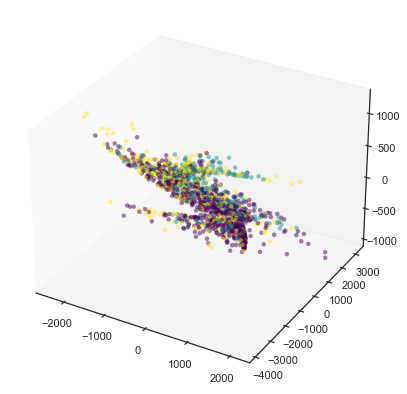

time: 12.2 s


In [19]:
for oc_svm in tqdm(OC_SVM):
    if "poly" not in oc_svm:
        data = extract_ocsvm_features(data, labels, oc_svm)

  0%|          | 0/5 [00:00<?, ?it/s]

extracting one-class scores of LDA components of FRILL embeddings...


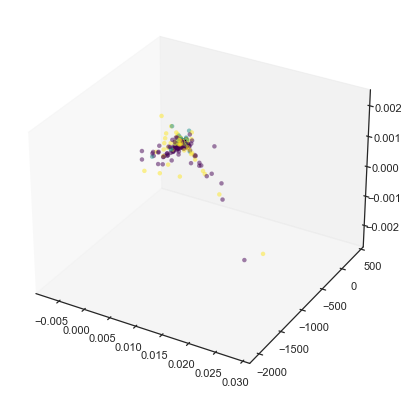

extracting one-class scores of LDA components of FRILL embeddings...


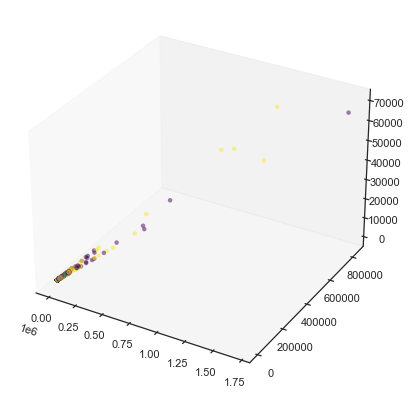

time: 5.59 s


In [20]:
for oc_svm in tqdm(OC_SVM):
    if "poly" in oc_svm:
        data = extract_ocsvm_features(data, labels, oc_svm)

# SGDOneClassSVM scores of FRILL embeddings and resultant LDA components

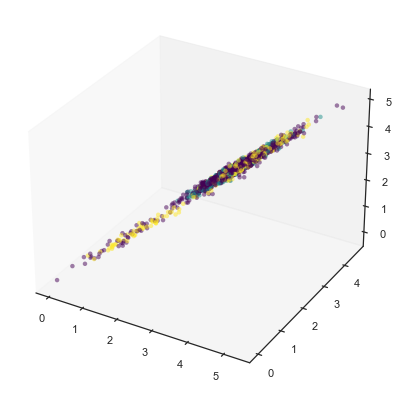

time: 662 ms


In [21]:
prefix = f"ocSVM_sgdlinear"
for valence in VALENCE.keys():
    feature = f"{prefix}_{valence}"
    data[feature] = load_extractor(feature).score_samples(frill)
    _ = gc_collect()
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]
plot3d(data, labels, *features)
checkpoint_features(data, features)

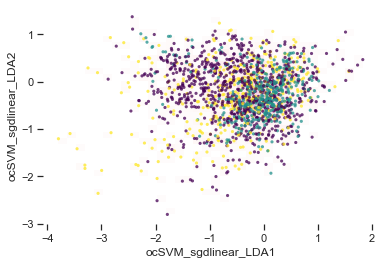

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     1657 non-null   float64
 1   LDA2                     1657 non-null   float64
 2   ocLDA_neg                1657 non-null   float64
 3   ocLDA_neu                1657 non-null   float64
 4   ocLDA_pos                1657 non-null   float64
 5   LDA-LOF_neg_30           1657 non-null   float64
 6   LDA-LOF_neu_30           1657 non-null   float64
 7   LDA-LOF_pos_30           1657 non-null   float64
 8   LDA-ocSVM_sgdlinear_neg  1657 non-null   float64
 9   LDA-ocSVM_sgdlinear_neu  1657 non-null   float64
 10  LDA-ocSVM_sgdlinear_pos  1657 non-null   float64
 11  LDA-ocSVM_rbf_neg        1657 non-null   float64
 12  LDA-ocSVM_rbf_neu        1657 non-null   float64
 13  LDA-ocSVM_rbf_pos        1657 non-null   float64
 14  LDA-ocSVM_sigmoid_neg   

In [22]:
prefix = "ocSVM_sgdlinear"
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]
features_ = ["ocSVM_sgdlinear_LDA1", "ocSVM_sgdlinear_LDA2"]
df = pd.DataFrame(
    load_extractor("_-_".join(features_)).transform(data.loc[:, features]),
    columns=features_,
)
df.index = labels.index
data = pd.concat([data, df], axis="columns")
_ = gc_collect()
assert not data.isnull().values.any()
plot2d(data, labels, *features_)
checkpoint_features(data, features_)
spot_check(data, labels)

# Spherical coordinates

In [23]:
features_ = [
    ["LDA1", "LDA2"],
    ["ocLDA_neg", "ocLDA_neu", "ocLDA_pos"],
    ["ocSVM_sgdlinear_LDA1", "ocSVM_sgdlinear_LDA2"],
    ["ocSVM_sgdlinear_neg", "ocSVM_sgdlinear_neu", "ocSVM_sgdlinear_pos"],
    ["LDA-LOF_neg_30", "LDA-LOF_neu_30", "LDA-LOF_pos_30"],
]

for descriptor in OC_SVM:
    features_.extend(
        [
            [
                f"LDA-ocSVM_{descriptor}_neg",
                f"LDA-ocSVM_{descriptor}_neu",
                f"LDA-ocSVM_{descriptor}_pos",
            ],
        ]
    )

all_features = []
for feature_set in features_:
    all_features.extend(feature_set)

_ = gc_collect()

time: 121 ms


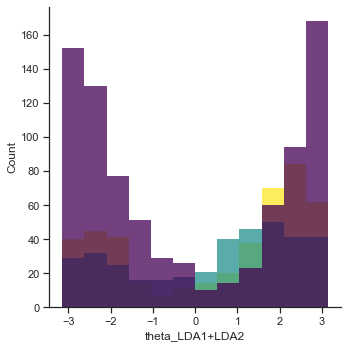

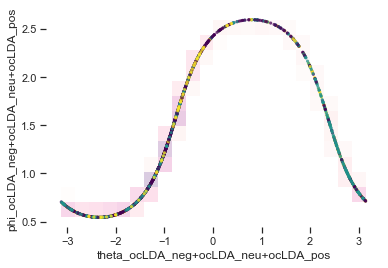

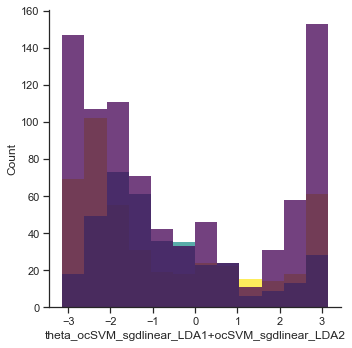

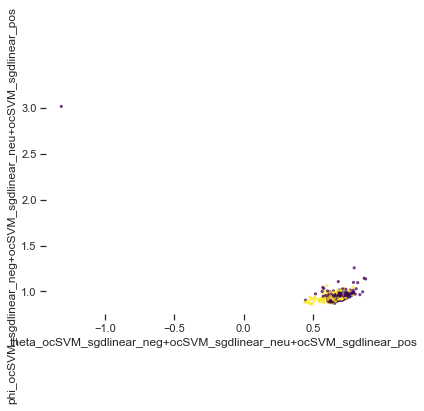

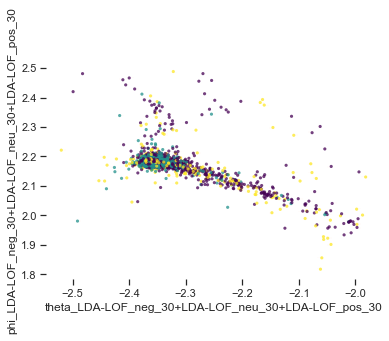

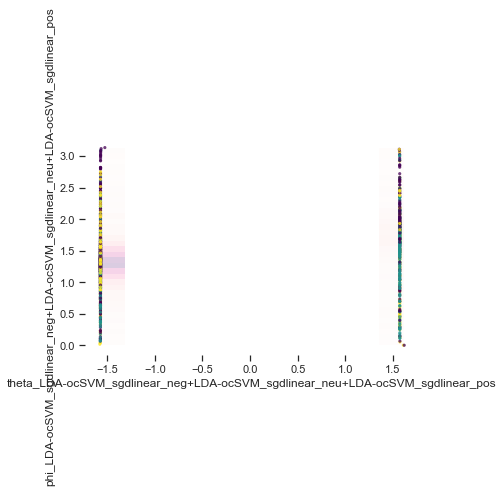

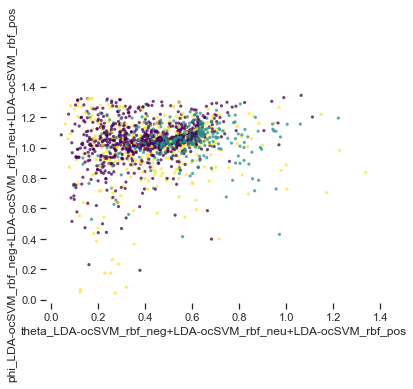

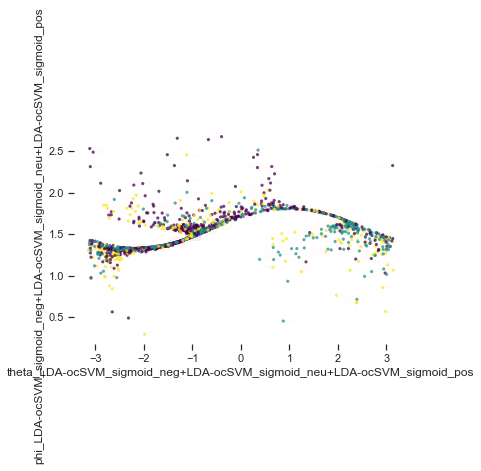

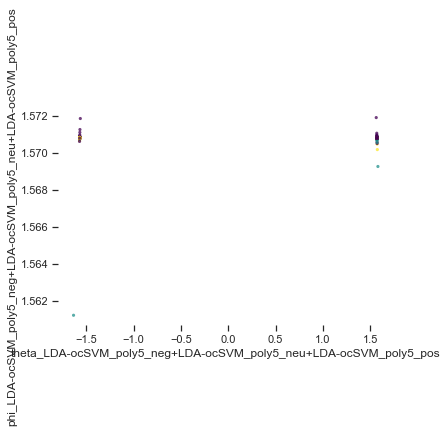

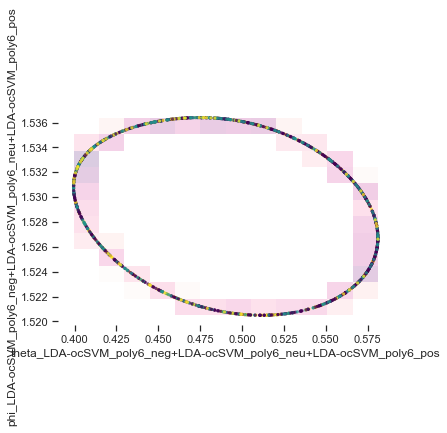

,theta_LDA1+LDA2,theta_ocLDA_neg+ocLDA_neu+ocLDA_pos,phi_ocLDA_neg+ocLDA_neu+ocLDA_pos,theta_ocSVM_sgdlinear_LDA1+ocSVM_sgdlinear_LDA2,theta_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos,phi_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos,theta_LDA-LOF_neg_30+LDA-LOF_neu_30+LDA-LOF_pos_30,phi_LDA-LOF_neg_30+LDA-LOF_neu_30+LDA-LOF_pos_30,theta_LDA-ocSVM_sgdlinear_neg+LDA-ocSVM_sgdlinear_neu+LDA-ocSVM_sgdlinear_pos,phi_LDA-ocSVM_sgdlinear_neg+LDA-ocSVM_sgdlinear_neu+LDA-ocSVM_sgdlinear_pos,theta_LDA-ocSVM_rbf_neg+LDA-ocSVM_rbf_neu+LDA-ocSVM_rbf_pos,phi_LDA-ocSVM_rbf_neg+LDA-ocSVM_rbf_neu+LDA-ocSVM_rbf_pos,theta_LDA-ocSVM_sigmoid_neg+LDA-ocSVM_sigmoid_neu+LDA-ocSVM_sigmoid_pos,phi_LDA-ocSVM_sigmoid_neg+LDA-ocSVM_sigmoid_neu+LDA-ocSVM_sigmoid_pos,theta_LDA-ocSVM_poly5_neg+LDA-ocSVM_poly5_neu+LDA-ocSVM_poly5_pos,phi_LDA-ocSVM_poly5_neg+LDA-ocSVM_poly5_neu+LDA-ocSVM_poly5_pos,theta_LDA-ocSVM_poly6_neg+LDA-ocSVM_poly6_neu+LDA-ocSVM_poly6_pos,phi_LDA-ocSVM_poly6_neg+LDA-ocSVM_poly6_neu+LDA-ocSVM_poly6_pos
0,2.717871,-1.488212,0.744614,2.644841,0.672125,0.889465,-2.209578,2.107258,-1.570773,1.199567,0.262588,0.893568,-1.714696,1.338637,-1.570794,1.570795,0.561267,1.522264
1,2.859957,-1.341178,0.843385,2.741326,0.678624,0.903627,-2.138112,2.061121,-1.570767,1.241357,0.205059,0.880891,-1.434876,1.375165,-1.570795,1.570795,0.575545,1.524164
2,2.420009,-1.931622,0.583001,2.556497,0.686930,0.904500,-2.238489,2.122868,-1.570791,1.086107,0.267542,0.626675,-2.339630,1.283519,-1.570790,1.570795,0.507800,1.520504
3,1.907763,-2.946825,0.632798,2.808850,0.664550,0.904399,-2.366313,2.203577,-1.570915,0.586309,0.546219,0.829455,-2.742810,1.173892,-1.570837,1.570794,0.413916,1.526358
4,2.418749,-1.933952,0.582534,2.723552,0.654634,0.883622,-2.253867,2.136921,-1.570791,1.085508,0.275438,0.654779,-2.336918,1.286086,-1.570790,1.570795,0.507531,1.520505


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 18 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   theta_LDA1+LDA2                                                                1657 non-null   float64
 1   theta_ocLDA_neg+ocLDA_neu+ocLDA_pos                                            1657 non-null   float64
 2   phi_ocLDA_neg+ocLDA_neu+ocLDA_pos                                              1657 non-null   float64
 3   theta_ocSVM_sgdlinear_LDA1+ocSVM_sgdlinear_LDA2                                1657 non-null   float64
 4   theta_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos              1657 non-null   float64
 5   phi_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos                1657 non-null   float64
 6   theta_LDA-LOF_neg_30+LDA

In [24]:
sphericals = {}
new_features = []
for features in features_:
    combo = "+".join(features)
    df = data.loc[:, features]
    x, y = df[features[0]], df[features[1]]
    theta, phi = f"theta_{combo}", f"phi_{combo}"
    sphericals[theta] = arctan2(y, x)
    all_features.append(theta)
    # convert to polar
    if len(features) == 3:
        sphericals[phi] = arctan2(sqrt(x ** 2 + y ** 2), df[features[2]])
        all_features.append(phi)
        plot2d(
            df := pd.DataFrame({theta: sphericals[theta], phi: sphericals[phi]}),
            labels,
            theta,
            phi,
        )
        assert not df.isnull().values.any()
        new_features.append([theta, phi])
    else:
        plot1d(df := pd.DataFrame({theta: sphericals[theta]}), labels, theta)
        assert not df.isnull().values.any()
        new_features.append([theta])
    del df
    del x
    del y
    del combo
    _ = gc_collect()
features_.extend(new_features)

sphericals = pd.DataFrame(sphericals)
sphericals.head()
sphericals.info()

In [25]:
assert all(sphericals.index == labels.index)
assert all(sphericals.index == data.index)
spot_check(data, labels)
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     1657 non-null   float64
 1   LDA2                     1657 non-null   float64
 2   ocLDA_neg                1657 non-null   float64
 3   ocLDA_neu                1657 non-null   float64
 4   ocLDA_pos                1657 non-null   float64
 5   LDA-LOF_neg_30           1657 non-null   float64
 6   LDA-LOF_neu_30           1657 non-null   float64
 7   LDA-LOF_pos_30           1657 non-null   float64
 8   LDA-ocSVM_sgdlinear_neg  1657 non-null   float64
 9   LDA-ocSVM_sgdlinear_neu  1657 non-null   float64
 10  LDA-ocSVM_sgdlinear_pos  1657 non-null   float64
 11  LDA-ocSVM_rbf_neg        1657 non-null   float64
 12  LDA-ocSVM_rbf_neu        1657 non-null   float64
 13  LDA-ocSVM_rbf_pos        1657 non-null   float64
 14  LDA-ocSVM_sigmoid_neg   

In [26]:
sphericals.columns = sphericals.columns.astype(str)
spot_check(sphericals, labels)
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 18 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   theta_LDA1+LDA2                                                                1657 non-null   float64
 1   theta_ocLDA_neg+ocLDA_neu+ocLDA_pos                                            1657 non-null   float64
 2   phi_ocLDA_neg+ocLDA_neu+ocLDA_pos                                              1657 non-null   float64
 3   theta_ocSVM_sgdlinear_LDA1+ocSVM_sgdlinear_LDA2                                1657 non-null   float64
 4   theta_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos              1657 non-null   float64
 5   phi_ocSVM_sgdlinear_neg+ocSVM_sgdlinear_neu+ocSVM_sgdlinear_pos                1657 non-null   float64
 6   theta_LDA-LOF_neg_30+LDA

  0%|          | 0/5 [00:00<?, ?it/s]

extracting one-class scores of LDA components of FRILL embeddings...


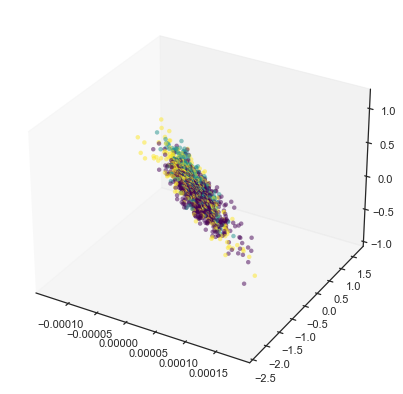

extracting one-class scores of LDA components of FRILL embeddings...


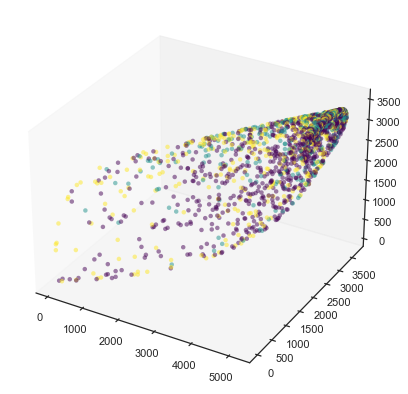

extracting one-class scores of LDA components of FRILL embeddings...


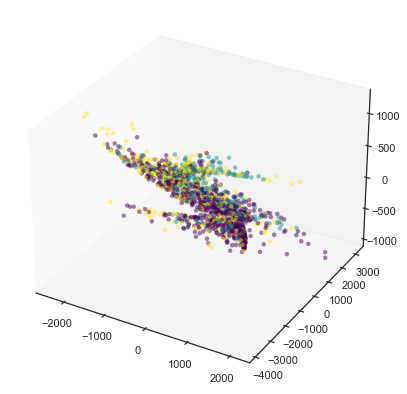

time: 11.3 s


In [27]:
for oc_svm in tqdm(OC_SVM):
    if "poly" not in oc_svm:
        data = extract_ocsvm_features(data, labels, oc_svm)

# LDA components of spherical FRILL-based features

In [28]:
features = ["spherical-LDA1", "spherical-LDA2"]
df = pd.DataFrame(
    load_extractor("_-_".join(features)).transform(sphericals), columns=features
)
all_features.extend(features)
assert all(df.index == labels.index)
assert all(df.index == data.index)
_ = gc_collect()

time: 132 ms


In [29]:
df_ = pd.concat(
    [
        data,
        df,
    ],
    axis="columns",
)
spot_check(df_, labels)
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     1657 non-null   float64
 1   LDA2                     1657 non-null   float64
 2   ocLDA_neg                1657 non-null   float64
 3   ocLDA_neu                1657 non-null   float64
 4   ocLDA_pos                1657 non-null   float64
 5   LDA-LOF_neg_30           1657 non-null   float64
 6   LDA-LOF_neu_30           1657 non-null   float64
 7   LDA-LOF_pos_30           1657 non-null   float64
 8   LDA-ocSVM_sgdlinear_neg  1657 non-null   float64
 9   LDA-ocSVM_sgdlinear_neu  1657 non-null   float64
 10  LDA-ocSVM_sgdlinear_pos  1657 non-null   float64
 11  LDA-ocSVM_rbf_neg        1657 non-null   float64
 12  LDA-ocSVM_rbf_neu        1657 non-null   float64
 13  LDA-ocSVM_rbf_pos        1657 non-null   float64
 14  LDA-ocSVM_sigmoid_neg   

In [30]:
data = deepcopy(df_)
spot_check(data, labels)
del df
del df_
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     1657 non-null   float64
 1   LDA2                     1657 non-null   float64
 2   ocLDA_neg                1657 non-null   float64
 3   ocLDA_neu                1657 non-null   float64
 4   ocLDA_pos                1657 non-null   float64
 5   LDA-LOF_neg_30           1657 non-null   float64
 6   LDA-LOF_neu_30           1657 non-null   float64
 7   LDA-LOF_pos_30           1657 non-null   float64
 8   LDA-ocSVM_sgdlinear_neg  1657 non-null   float64
 9   LDA-ocSVM_sgdlinear_neu  1657 non-null   float64
 10  LDA-ocSVM_sgdlinear_pos  1657 non-null   float64
 11  LDA-ocSVM_rbf_neg        1657 non-null   float64
 12  LDA-ocSVM_rbf_neu        1657 non-null   float64
 13  LDA-ocSVM_rbf_pos        1657 non-null   float64
 14  LDA-ocSVM_sigmoid_neg   

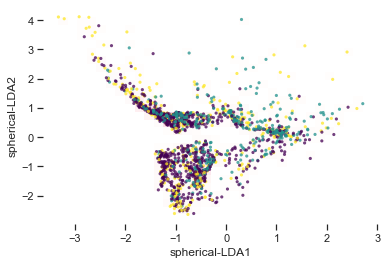

time: 156 ms


In [31]:
plot2d(data, labels, *features)
checkpoint_features(data, features)

# One-class LDA components of spherical FRILL-based features

In [32]:
df = pd.concat(
    [
        data,
        pd.DataFrame(
            {
                feature: np.squeeze(load_extractor(feature).transform(sphericals))
                for feature in feature_trio("spherical-ocLDA", "")
            }
        ),
    ],
    axis="columns",
)
spot_check(df, labels)
all_features.extend(feature_trio("spherical-ocLDA", ""))
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     1657 non-null   float64
 1   LDA2                     1657 non-null   float64
 2   ocLDA_neg                1657 non-null   float64
 3   ocLDA_neu                1657 non-null   float64
 4   ocLDA_pos                1657 non-null   float64
 5   LDA-LOF_neg_30           1657 non-null   float64
 6   LDA-LOF_neu_30           1657 non-null   float64
 7   LDA-LOF_pos_30           1657 non-null   float64
 8   LDA-ocSVM_sgdlinear_neg  1657 non-null   float64
 9   LDA-ocSVM_sgdlinear_neu  1657 non-null   float64
 10  LDA-ocSVM_sgdlinear_pos  1657 non-null   float64
 11  LDA-ocSVM_rbf_neg        1657 non-null   float64
 12  LDA-ocSVM_rbf_neu        1657 non-null   float64
 13  LDA-ocSVM_rbf_pos        1657 non-null   float64
 14  LDA-ocSVM_sigmoid_neg   

In [33]:
data = pd.concat([df, sphericals], axis="columns")
spot_check(data, labels)
_ = gc_collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 51 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           1657 non-null   float64
 1   LDA2                                                                           1657 non-null   float64
 2   ocLDA_neg                                                                      1657 non-null   float64
 3   ocLDA_neu                                                                      1657 non-null   float64
 4   ocLDA_pos                                                                      1657 non-null   float64
 5   LDA-LOF_neg_30                                                                 1657 non-null   float64
 6   LDA-LOF_neu_30          

In [34]:
training_data = (
    pd.read_feather(f"./scaled_features_ready_for_selection.feather")
    .set_index("id")
    .head(1)
)
assert sorted(all_features) == sorted(list(data.columns))
assert set(training_data.columns) - set(all_features) == set()
assert set(training_data.columns) - set(data.columns) == set()
assert len(data.columns) == len(training_data.columns)
assert set(data.columns) == set(training_data.columns)
data = data.loc[
    :, training_data.columns
]  # with the guarantee of the preceding assertion, ensure congruent column order
assert all(data.columns == training_data.columns)
del sphericals
del training_data
_ = gc_collect()

time: 146 ms


# Robust scaling

In [35]:
scaler = load_extractor("robust_scaler")
data = pd.DataFrame(scaler.transform(data), columns=scaler.feature_names_in_)
del scaler
_ = gc_collect()
spot_check(data, labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 51 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           1657 non-null   float64
 1   LDA2                                                                           1657 non-null   float64
 2   ocLDA_neg                                                                      1657 non-null   float64
 3   ocLDA_neu                                                                      1657 non-null   float64
 4   ocLDA_pos                                                                      1657 non-null   float64
 5   ocSVM_sgdlinear_LDA1                                                           1657 non-null   float64
 6   ocSVM_sgdlinear_LDA2    

In [36]:
data.columns = data.columns.astype(str)
data.to_feather(f"{OUT_FOLDER}/holdout_featurized.feather")
data = pd.read_feather(f"{OUT_FOLDER}/holdout_featurized.feather")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 51 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           1657 non-null   float64
 1   LDA2                                                                           1657 non-null   float64
 2   ocLDA_neg                                                                      1657 non-null   float64
 3   ocLDA_neu                                                                      1657 non-null   float64
 4   ocLDA_pos                                                                      1657 non-null   float64
 5   ocSVM_sgdlinear_LDA1                                                           1657 non-null   float64
 6   ocSVM_sgdlinear_LDA2    

,LDA1,LDA2,ocLDA_neg,ocLDA_neu,ocLDA_pos,ocSVM_sgdlinear_LDA1,ocSVM_sgdlinear_LDA2,ocSVM_sgdlinear_neg,ocSVM_sgdlinear_neu,ocSVM_sgdlinear_pos,...,theta_LDA-ocSVM_sgdlinear_neg+LDA-ocSVM_sgdlinear_neu+LDA-ocSVM_sgdlinear_pos,phi_LDA-ocSVM_sgdlinear_neg+LDA-ocSVM_sgdlinear_neu+LDA-ocSVM_sgdlinear_pos,theta_LDA-ocSVM_rbf_neg+LDA-ocSVM_rbf_neu+LDA-ocSVM_rbf_pos,phi_LDA-ocSVM_rbf_neg+LDA-ocSVM_rbf_neu+LDA-ocSVM_rbf_pos,theta_LDA-ocSVM_sigmoid_neg+LDA-ocSVM_sigmoid_neu+LDA-ocSVM_sigmoid_pos,phi_LDA-ocSVM_sigmoid_neg+LDA-ocSVM_sigmoid_neu+LDA-ocSVM_sigmoid_pos,theta_LDA-ocSVM_poly5_neg+LDA-ocSVM_poly5_neu+LDA-ocSVM_poly5_pos,phi_LDA-ocSVM_poly5_neg+LDA-ocSVM_poly5_neu+LDA-ocSVM_poly5_pos,theta_LDA-ocSVM_poly6_neg+LDA-ocSVM_poly6_neu+LDA-ocSVM_poly6_pos,phi_LDA-ocSVM_poly6_neg+LDA-ocSVM_poly6_neu+LDA-ocSVM_poly6_pos
0,-1.366451,0.750510,0.125657,-1.169099,1.718413,-1.770233,1.041069,-0.043879,-0.303903,0.234940,...,-0.000081,-0.953945,-1.725941,-2.121466,-0.548530,-1.263178,-0.000040,-1.243832,0.705719,-1.037581
1,-1.618546,0.571809,0.399217,-1.444952,1.757759,-1.408577,0.635000,-0.113355,-0.334635,0.090899,...,-0.000078,-0.860097,-2.048652,-2.254905,-0.433003,-1.080806,-0.000040,-0.970360,0.861545,-0.803346
2,-1.468999,1.545608,-0.479339,-1.127729,2.423153,-1.347075,0.956787,0.204692,0.054931,0.429172,...,-0.000088,-1.208742,-1.698153,-4.930833,-0.806541,-1.538361,-0.000038,-1.541045,0.122160,-1.254582
3,-0.448719,1.667142,-1.089839,-0.117787,1.786355,-1.823446,0.678919,0.845212,0.547808,1.010617,...,-0.000142,-2.331139,-0.134907,-2.796339,-0.972999,-2.085682,-0.000058,-2.351112,-0.902503,-0.532811
4,-1.423972,1.504501,-0.467925,-1.091383,2.358169,-2.267592,1.101667,0.357508,-0.015923,0.644714,...,-0.000088,-1.210087,-1.653857,-4.635003,-0.805421,-1.525544,-0.000038,-1.539919,0.119226,-1.254441


time: 52.4 ms


In [37]:
training_data = (
    pd.read_feather(f"./scaled_features_ready_for_selection.feather")
    .set_index("id")
    .head(1)
)
assert sorted(all_features) == sorted(list(data.columns))
assert set(training_data.columns) - set(all_features) == set()
assert set(all_features) - set(training_data.columns) == set()
assert set(data.columns) - set(training_data.columns) == set()
assert len(data.columns) == len(training_data.columns)
assert set(data.columns) == set(training_data.columns)
_ = gc_collect()

time: 147 ms


# Final visualization

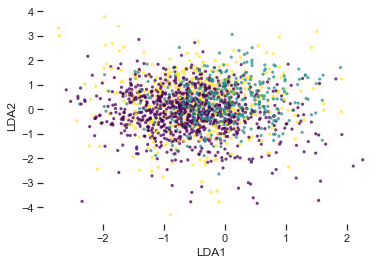

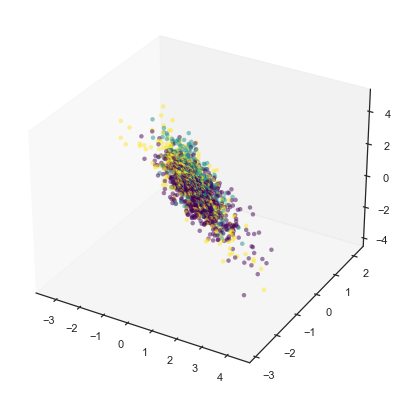

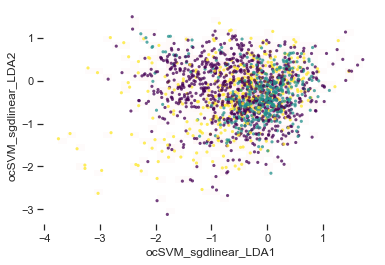

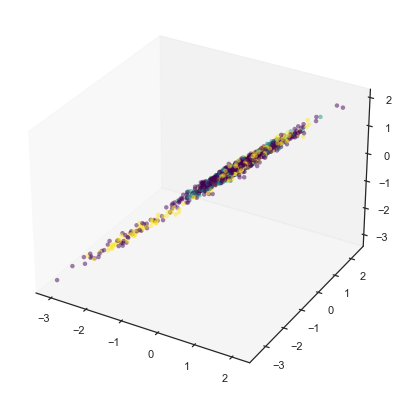

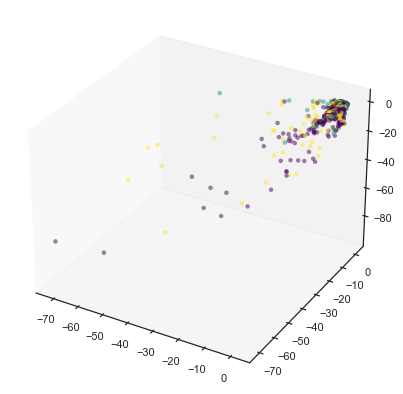

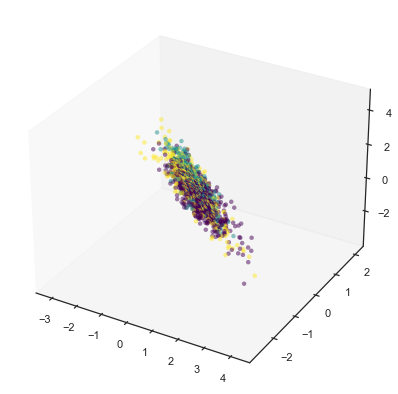

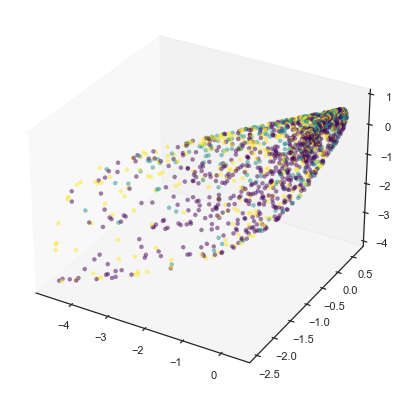

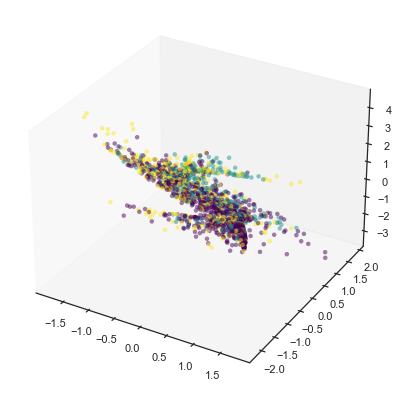

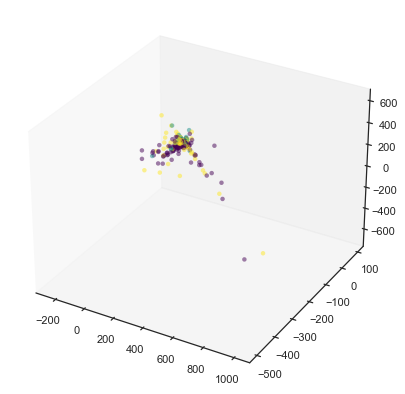

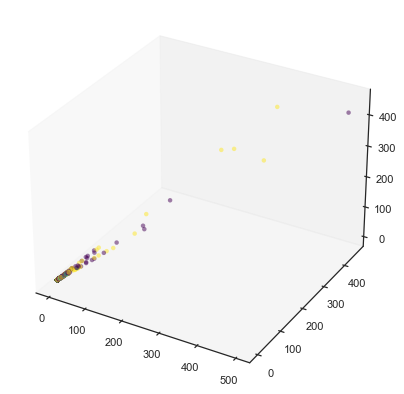

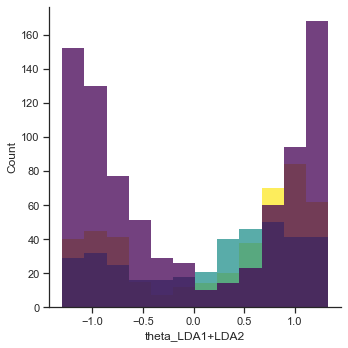

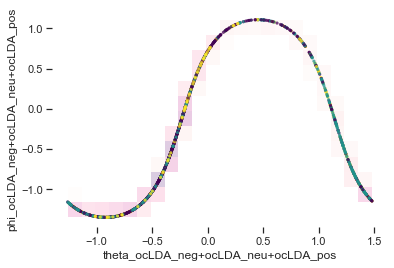

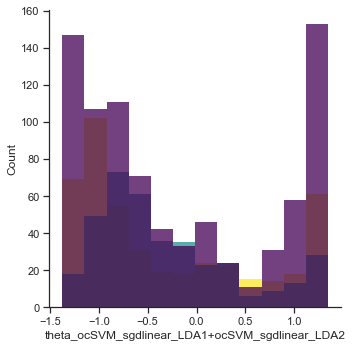

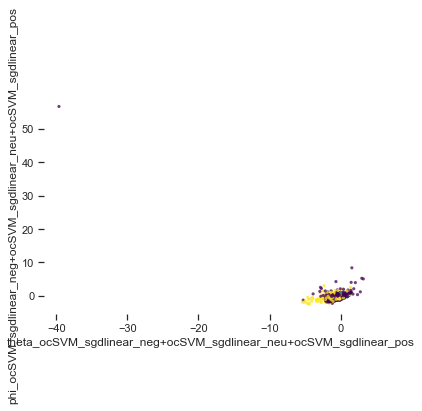

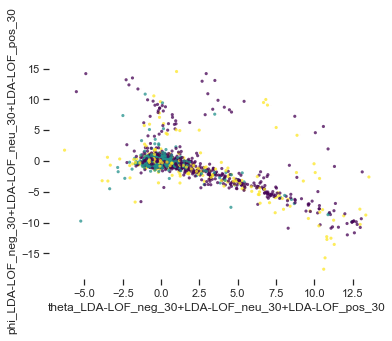

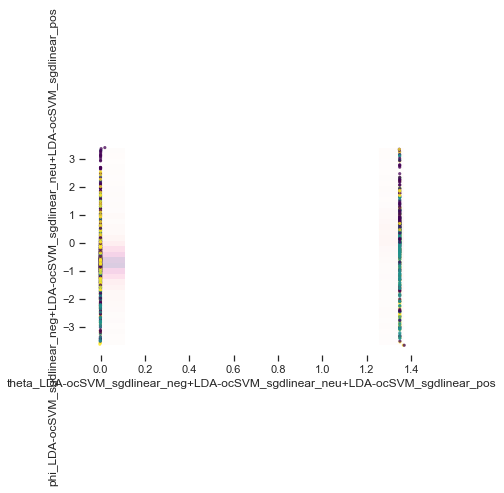

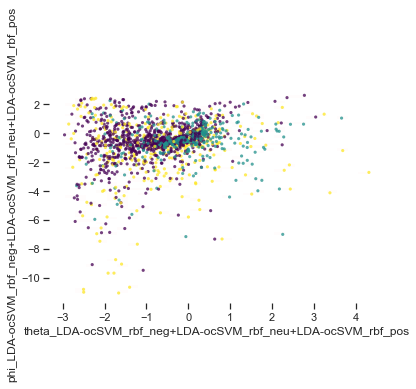

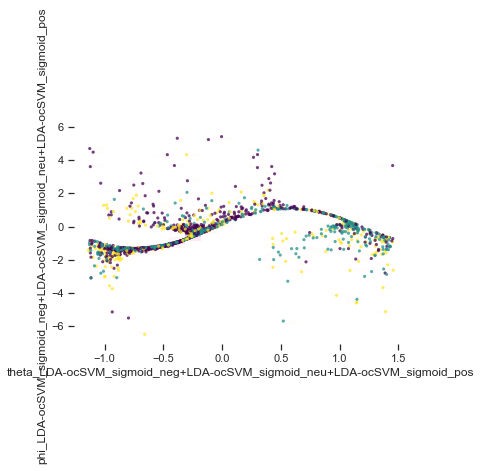

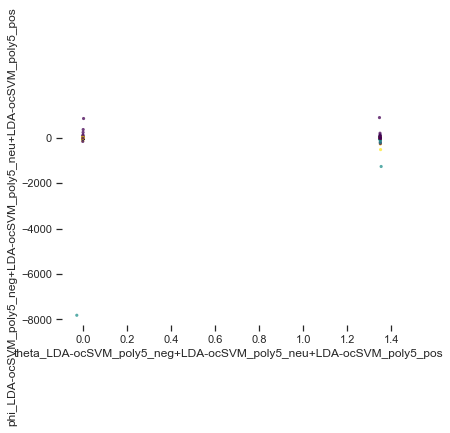

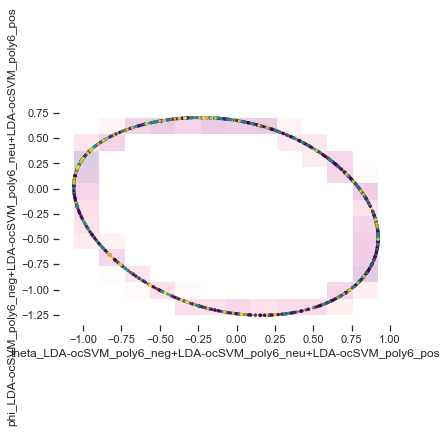

time: 4.02 s


In [38]:
for features in features_:
    if len(features) == 3:
        plot3d(data, labels, *features)
    elif len(features) == 2:
        plot2d(data, labels, *features)
    else:
        plot1d(data, labels, *features)

# Discussion

Now that we have the features, let's evaluate them in the next notebook. The visualizations don't look so clean, so let's hope for the best.|

In [39]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 54.32407259941101 s
time: 149 ms


[^top](#Contents)